In [26]:
import json

with open('new_all_qguide_data.html', 'r') as file:
    json_data = json.load(file)

with open('new_all_qguide_data.json', 'w') as file:
    json.dump(json_data, file, separators=(',', ':'))


In [37]:
# from bs4 import BeautifulSoup
# import pandas as pd
# import requests
# from tabulate import tabulate

# def extract_table_data(url):
#     # Fetch the HTML content from the URL
#     response = requests.get(url)
#     html = response.text

#     # Parse the HTML
#     soup = BeautifulSoup(html, 'html.parser')

#     # Define table names
#     table_names = ['Responses', 'General', 'Instructor', 'Hours', 'Recommendation', 'Recommendation_stats', 'Reasons', 'Will_tochange', 'Open_mind', 'Comments']

#     # Find all tables containing the required data
#     tables = soup.find_all('table')

#     # Create a dictionary to store DataFrames for each table
#     dataframes = {}

#     # Iterate through each table
#     for idx, table in enumerate(tables):
#         # Extract headers
#         headers = []
#         for th in table.find('tr').find_all('th'):
#             headers.append(th.text.strip())

#         # Extract data rows
#         data = []
#         for row in table.find_all('tr'):
#             row_data = [cell.text.strip() for cell in row.find_all(['td', 'th'])]
#             if len(row_data) == len(headers):
#                 data.append(row_data)

#         # If data rows exist
#         if len(data) > 1:
#             # Create a DataFrame excluding the header row
#             df = pd.DataFrame(data[1:], columns=headers)
#             dataframes[table_names[idx]] = df

#     return dataframes


In [59]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

def extract_table_data(url):
    response = requests.get(url)
    html = response.text

    soup = BeautifulSoup(html, 'html.parser')

    # THIS PROBABLY IS BAD LONG-TERM BUT I"M FUCKING ANNOYED
    captions_to_skip = [
        "Table for [QTitle]-In this course, most students listen attentively with an open mind and a willingness to change their point of view as they learn more about the topic.-Statistics.",
        "Table for [QTitle]-In this course (including sections), I feel comfortable expressing my views on controversial topics.-Statistics.",
        "Table for [qtitle]-in this course, most students listen attentively with an open mind and a willingness to change their point of view as they learn more about the topic..",
        "Table for [qtitle]-in this course (including sections), i feel comfortable expressing my views on controversial topics..",
        "Table for [qtitle]-in this course, most students listen attentively with an open mind and a willingness to change their point of view as they learn more about the topic..",
    ]

    captions_to_skip = [caption.lower().strip() for caption in captions_to_skip]

    tables = soup.find_all('table')

    dataframes = {}

    table_index = 0

    for table in tables:
        caption_tag = table.find('caption')
        
        if caption_tag:
            caption_text = caption_tag.text.strip().lower()
            
            if any(skip_caption in caption_text for skip_caption in captions_to_skip):
                continue

        headers = [th.text.strip() for th in table.find('tr').find_all('th')]

        data = []
        for row in table.find_all('tr'):
            row_data = [cell.text.strip() for cell in row.find_all(['td', 'th'])]
            if len(row_data) == len(headers):
                data.append(row_data)

        if len(data) > 1:
            df = pd.DataFrame(data[1:], columns=headers)
            dataframes[f'Table_{table_index}'] = df
            table_index += 1

    return dataframes


In [60]:
# Example usage:
url = "https://harvard.bluera.com/harvard/rpv-eng.aspx?lang=eng&redi=1&SelectedIDforPrint=2a25bbb354dd26d2a5018145b3eccac802438e93cb86651665bfd7dc8f5e8b888dcf958e60eb641327093338906fe195&ReportType=2&regl=en-US"
tables_data = extract_table_data(url)

# Print each table with its name
for table_name, table_df in tables_data.items():
    print(f"Table '{table_name}':")
    print(tabulate(table_df, headers='keys', tablefmt='grid'))
    print()

Table 'Table_0':
+----+----------------+------------+
|    | Raters         | Students   |
+====+================+============+
|  0 | Responded      | 5          |
+----+----------------+------------+
|  1 | Invited        | 7          |
+----+----------------+------------+
|  2 | Response Ratio | 71%        |
+----+----------------+------------+

Table 'Table_1':
+----+--------------------------------------------------------------------------------------------+---------+-------------+-------------+--------+--------+------------------+---------------+------------+
|    |                                                                                            |   Count | Excellent   | Very Good   | Good   | Fair   | Unsatisfactory   |   Course Mean |   FAS Mean |
+====+============================================================================================+=========+=============+=============+========+========+==================+===============+============+
|  0 | Evaluate the 

In [64]:
import json
import time

with open('new_all_qguide_data.json', 'r') as f:
    all_qguide_data = json.load(f)

course_data_list = []

start_time = time.time()

total_entries = len(all_qguide_data['data'])

processed_entries = 0

for entry in all_qguide_data['data']:
    iteration_start_time = time.time()

    course_data = {}
    for key in ['title', 'url', 'instructor', 'department', 'term', 'subject', 'blueCourseId']:
        if key in entry:
            course_data[key.capitalize()] = entry[key]
        # else:
        #     # If blueCourseId is missing, assign 0
        #     if key == 'blueCourseId':
        #         course_data['Bluecourseid'] = "POST-SPRING2024"

    tables_data = extract_table_data(entry['url'])

    tables_data_dict = {table_name: table_df.to_dict(orient='records') for table_name, table_df in tables_data.items()}

    course_data['Feedback'] = tables_data_dict

    course_data_list.append(course_data)

    processed_entries += 1

    iteration_elapsed_time = time.time() - iteration_start_time

    percent_finished = (processed_entries / total_entries) * 100

    avg_time_per_iteration = (time.time() - start_time) / processed_entries

    remaining_entries = total_entries - processed_entries
    remaining_time_seconds = remaining_entries * avg_time_per_iteration

    hours = int(remaining_time_seconds // 3600)
    remaining_time_seconds %= 3600
    minutes = int(remaining_time_seconds // 60)
    seconds = int(remaining_time_seconds % 60)

    print(f"Iteration {processed_entries}/{total_entries} - {percent_finished:.2f}% completed - Time taken: {iteration_elapsed_time:.2f}s - Estimated time remaining: {hours}h {minutes}m {seconds}s")

end_time = time.time()

with open('new_course_data.json', 'w') as json_file:
    json.dump(course_data_list, json_file, indent=4)


Iteration 1/9372 - 0.01% completed - Time taken: 0.62s - Estimated time remaining: 1h 36m 29s
Iteration 2/9372 - 0.02% completed - Time taken: 0.31s - Estimated time remaining: 1h 12m 33s
Iteration 3/9372 - 0.03% completed - Time taken: 0.21s - Estimated time remaining: 0h 59m 24s
Iteration 4/9372 - 0.04% completed - Time taken: 0.43s - Estimated time remaining: 1h 1m 22s
Iteration 5/9372 - 0.05% completed - Time taken: 0.19s - Estimated time remaining: 0h 55m 7s
Iteration 6/9372 - 0.06% completed - Time taken: 0.36s - Estimated time remaining: 0h 55m 16s
Iteration 7/9372 - 0.07% completed - Time taken: 0.39s - Estimated time remaining: 0h 56m 1s
Iteration 8/9372 - 0.09% completed - Time taken: 0.22s - Estimated time remaining: 0h 53m 16s
Iteration 9/9372 - 0.10% completed - Time taken: 0.39s - Estimated time remaining: 0h 54m 9s
Iteration 10/9372 - 0.11% completed - Time taken: 0.43s - Estimated time remaining: 0h 55m 28s
Iteration 11/9372 - 0.12% completed - Time taken: 0.21s - Estim

In [65]:
import json

def add_unique_courses(json1, json2):
    # Create a set of Bluecourseid from the first JSON to keep track of added courses
    existing_course_ids = {course['Bluecourseid'] for course in json1}
    
    # Loop through the second JSON and add courses that don't exist in the first
    for course in json2:
        if course['Bluecourseid'] not in existing_course_ids:
            json1.append(course)  # Add the new course to the first JSON
    
    return json1

# Load JSON data from files
with open('course_data.json', 'r') as file1:
    json1 = json.load(file1)

with open('new_course_data.json', 'r') as file2:
    json2 = json.load(file2)

# Add unique courses from json2 to json1
combined_json = add_unique_courses(json1, json2)

# Save the combined JSON array
with open('2020-2024_Course_Data.json', 'w') as outfile:
    json.dump(combined_json, outfile, indent=4)


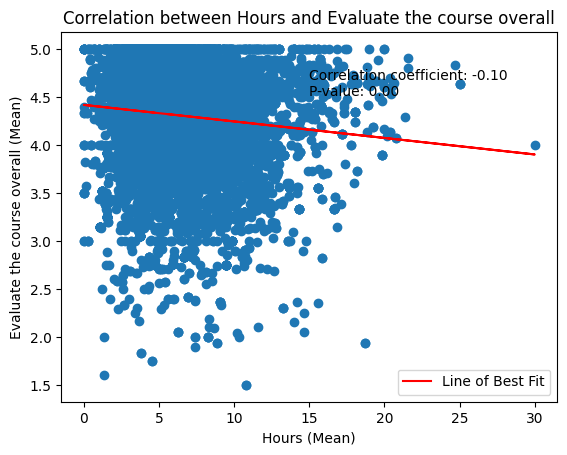

In [67]:
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the JSON data
with open('2020-2024_Course_Data.json', 'r') as file:
    data = json.load(file)

# Initialize lists to store hours and overall evaluation ratings
hours = []
course_scores = []

# Iterate through each entry in the data
for entry in data:
    # Check if the entry has a 'Feedback' dictionary with 'Hours' and 'General' keys
    if 'Feedback' in entry and 'Hours' in entry['Feedback'] and 'General' in entry['Feedback']:
        # Extract hours and overall evaluation rating
        hours_data = entry['Feedback']['Hours']
        overall_data = entry['Feedback']['General'][0]

        # Check if hours_data has at least three elements and the third element is a dictionary with a 'Value' key
        if len(hours_data) > 2 and isinstance(hours_data[2], dict) and 'Value' in hours_data[2]:
            # Convert hours value to float and append to the list
            hours.append(float(hours_data[2]['Value']))
        else:
            # Handle missing or invalid hours data
            hours.append(np.nan)

        # Convert overall evaluation rating to float and append to the list
        course_scores.append(float(overall_data['Course Mean']))
    else:
        # Handle missing 'Feedback', 'Hours', or 'General' keys
        hours.append(np.nan)
        course_scores.append(np.nan)

# Convert lists to numpy arrays for correlation calculation
hours_array = np.array(hours)
course_scores_array = np.array(course_scores)

# Remove NaN values from the arrays
valid_indices = ~np.isnan(hours_array) & ~np.isnan(course_scores_array)
hours_array = hours_array[valid_indices]
course_scores_array = course_scores_array[valid_indices]

# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(hours_array, course_scores_array)

# Fit a linear regression line
slope, intercept = np.polyfit(hours_array, course_scores_array, 1)
line_of_best_fit = slope * hours_array + intercept

# Plot the data
plt.scatter(hours_array, course_scores_array)
plt.plot(hours_array, line_of_best_fit, color='red', label='Line of Best Fit')
plt.xlabel('Hours (Mean)')
plt.ylabel('Evaluate the course overall (Mean)')
plt.title('Correlation between Hours and Evaluate the course overall')
plt.text(0.5, 0.9, f'Correlation coefficient: {correlation_coefficient:.2f}\nP-value: {p_value:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.legend()
plt.show()

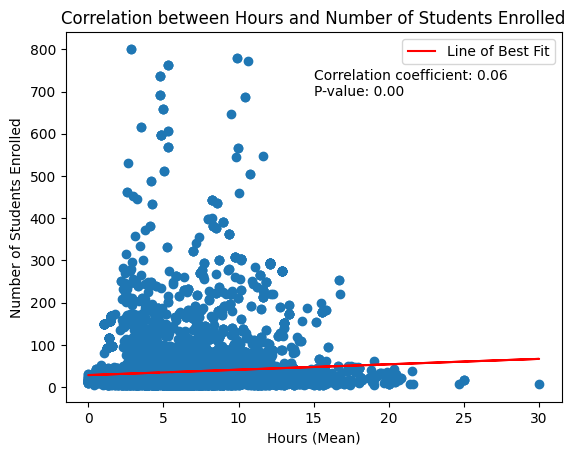

In [68]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the JSON data
with open('2020-2024_Course_Data.json', 'r') as file:
    data = json.load(file)

# Initialize lists to store hours and overall evaluation ratings
hours = []
course_scores = []

# Iterate through each entry in the data
for entry in data:
    # Check if the entry has a 'Feedback' dictionary with 'Hours' and 'Responses' keys
    if 'Feedback' in entry and 'Hours' in entry['Feedback'] and 'Responses' in entry['Feedback']:
        # Extract hours and overall evaluation rating
        hours_data = entry['Feedback']['Hours']
        responses = entry['Feedback']['Responses']

        # Check if 'Responses' list has at least two elements
        if len(responses) > 1:
            # Check if hours_data has at least three elements and the third element is a dictionary with a 'Value' key
            if len(hours_data) > 2 and isinstance(hours_data[2], dict) and 'Value' in hours_data[2]:
                # Convert hours value to float and append to the list
                hours.append(float(hours_data[2]['Value']))

                # Convert overall evaluation rating to float and append to the list
                course_scores.append(float(responses[1]['Students']))
            else:
                # Handle missing or invalid hours data
                hours.append(np.nan)
                course_scores.append(np.nan)
        else:
            # Handle missing or invalid 'Responses' data
            hours.append(np.nan)
            course_scores.append(np.nan)
    else:
        # Handle missing 'Feedback', 'Hours', or 'Responses' keys
        hours.append(np.nan)
        course_scores.append(np.nan)

# Convert lists to numpy arrays for correlation calculation
hours_array = np.array(hours)
course_scores_array = np.array(course_scores)

# Remove NaN values from the arrays
valid_indices = ~np.isnan(hours_array) & ~np.isnan(course_scores_array)
hours_array = hours_array[valid_indices]
course_scores_array = course_scores_array[valid_indices]

# Calculate the correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(hours_array, course_scores_array)

# Fit a linear regression line
slope, intercept = np.polyfit(hours_array, course_scores_array, 1)
line_of_best_fit = slope * hours_array + intercept

# Plot the data
plt.scatter(hours_array, course_scores_array)
plt.plot(hours_array, line_of_best_fit, color='red', label='Line of Best Fit')
plt.xlabel('Hours (Mean)')
plt.ylabel('Number of Students Enrolled')
plt.title('Correlation between Hours and Number of Students Enrolled')
plt.text(0.5, 0.9, f'Correlation coefficient: {correlation_coefficient:.2f}\nP-value: {p_value:.2f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.legend()
plt.show()

In [73]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Load the JSON data
with open('2020-2024_Course_Data.json', 'r') as file:
    data = json.load(file)

# Extract relevant features and target variable
features = []
target = []

for entry in data:
    if 'Feedback' in entry and 'General' in entry['Feedback']:  # Check if 'Feedback' and 'General' exist
        for feedback in entry['Feedback']['General']:
            if feedback.get('') == "Evaluate the course overall.":
                course_mean = float(feedback['Course Mean'])

                feature_values = []

                course_eval = entry['Feedback']['General']

                for course_key in range(1, 5):
                    if course_key < len(course_eval):
                        course_means = course_eval[course_key].get('Course Mean')
                        if instructor_mean is not None:
                            try:
                                feature_values.append(float(course_means))
                            except ValueError:
                                feature_values.append(np.nan)  # Append NaN for invalid values
                        else:
                            feature_values.append(np.nan)
                    else:
                        feature_values.append(np.nan)  # Append NaN if instructor key doesn't exist

                instructors = entry['Feedback']['Instructor']
                
                for instructor_key in range(7):
                    if instructor_key < len(instructors):
                        instructor_mean = instructors[instructor_key].get('Instructor Mean')
                        if instructor_mean is not None:
                            try:
                                feature_values.append(float(instructor_mean))
                            except ValueError:
                                feature_values.append(np.nan)  # Append NaN for invalid values
                        else:
                            feature_values.append(np.nan)
                    else:
                        feature_values.append(np.nan)  # Append NaN if instructor key doesn't exist
                
                hours = entry['Feedback'].get('Hours', [])
                if len(hours) > 2 and 'Value' in hours[2]:
                    try:
                        feature_values.append(float(hours[2]['Value']))
                    except ValueError:
                        feature_values.append(np.nan)  # Append NaN for invalid values
                else:
                    feature_values.append(np.nan)  # Append NaN if 'Value' key doesn't exist or 'Hours' list is too short
                
                features.append(feature_values)
                # Classify course mean into 'good' (1) or 'not good' (0)
                target.append(1 if course_mean >= 4.5 else 0)

# Convert lists to numpy arrays
X = np.array(features)
y = np.array(target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1010101)

# Train a random forest classifier
clf = RandomForestClassifier(random_state=1010101)
clf.fit(X_train, y_train)

# Plot feature importances
plt.figure(figsize=(10, 6))
n_features = X.shape[1]
bars = plt.barh(range(n_features), clf.feature_importances_, align='center')
plt.yticks(np.arange(n_features), ['Course materials (readings, audio-visual materials, textbooks, lab manuals, website, etc.)',
                                   'Assignments (exams, essays, problem sets, language homework, etc.)',
                                   'Feedback received on work produced in this course',
                                   'Section component',
                                   'Instructor overall evaluation',
                                   'Effective lectures',
                                   'Available outside class',
                                   'Generates enthusiasm',
                                   'Facilitates discussion encourages participation',
                                   'Useful feedback',
                                   'Returns assignments timely',
                                   'Hours mean',]
                                   [:n_features])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.title('Random Forest Variable Importance (Course Overall Score 4.5 target)')

# Add text annotations
for bar, importance in zip(bars, clf.feature_importances_):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{importance:.5f}', va='center')

plt.show()


NameError: name 'instructor_mean' is not defined